In [1]:
from experiments import *
from translocation_models import *
import matplotlib.pyplot as plt

In [2]:
sc2r = SC2R()
disc_spiral = DiscSpiral()

# Convergence plot comparing analytical and empirical std
trajectories = sc2r.gillespie(max_time=100, n_simulations=1000, cumulative_sums='position')
end_positions = [trajectory['position'].iloc[-1] for trajectory in trajectories]

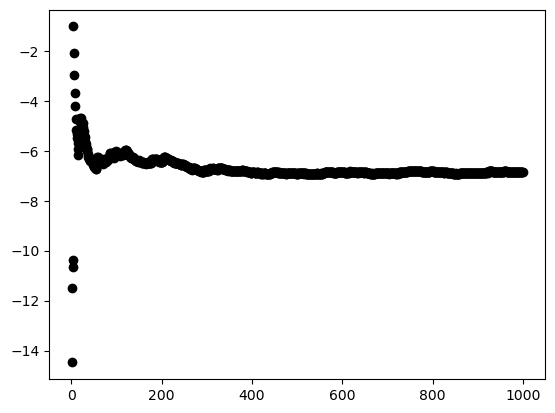

In [3]:
analytical_std = (sc2r.analytical_attribute_stats('position', float(100)))['std']
for i in range(1, len(end_positions)):
    empirical_std = np.std(end_positions[:i])
    plt.plot(i, empirical_std-analytical_std, 'o', color='black')
